# Andromeda with Image Data in Jupyter 


### Pre-trained Deep Learning Model for Feature Extraction
**ResNet18 Feature Extractor** extracts features from images at the last convolutional layer, apply average pooling on each feature map, then we got 512 features for each image.


### Interactive Inverse Dimension Reduction 

This notebook implements interactive dimension reduction (DR) for exploratory analysis of high-dimensional data.
It uses a Multi-Dimensional Scaling (MDS) algorithm with a weighted distance metric. It enables both forward and inverse DR interaction. 

**MDS** projects high-dimensional data to a 2D scatterplot. A **weighted distance function** with user-specified weights on each dimension enables alternative projections that emphasize different dimensions. An **Inverse-DR** algorithm learns distance function weights for  user-constructed layouts of the data points.


### CNN Feature Interpretability  

We use **Visual Back Propagation** method to back propagate each feature map, then apply the learned weights from Inverse DR model to the back propogated feature maps, add the final maps together to get the final attention.


### Instructions:

1. Change the variable name of the first file **ImgFolder** to your own image folder path
1. Click "Kernel" in the menu bar --> then click "Restart Kernel and Run All"
1. Proceed to the interactive plots near the bottom
1. There are three kinds of interactions:
    1. **Projection interaction:** Drag images in the projection plot to form user-defined clusters, then click Learn to see learned weights, and click Copy to see the updated projection plot.
    1. **Print Activation Map:** Click the "Print features" button at the bottom of the notebook to see which part of the original image is focused by the underlying model to form user-defined image groups.
1. Be patient, its interactive matplotlib in python and Jupyter!


Based on: 
1. *Self JZ, Dowling M, Wenskovitch J, Crandell I, Wang M, House L, Leman S, North C. Observation-Level and Parametric Interaction for High-Dimensional Data Analysis. ACM Transactions on Interactive Intelligent Systems.  8(2), 2018.* https://infovis.cs.vt.edu/sites/default/files/observation-level-parametric_first_look_version.pdf
2. *Mariusz Bojarski, Anna Choromanska, Krzysztof Choromanski, Bernhard Firner, Larry Jackel, Urs Muller, Karol Zieba. VisualBackProp: efficient visualization of CNNs.* https://arxiv.org/abs/1611.05418v3



In [1]:
%matplotlib notebook

### interactive notebook format is required for the interactive plot

import numpy as np
import pandas as pd
import math
import random
import os
import cv2
from skimage.transform import resize
import csv
from tqdm import tqdm

from os import listdir
from os.path import isfile, join
from math import isnan

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import sklearn.metrics.pairwise

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.patches import FancyBboxPatch
from functools import partial
import ipywidgets as widgets
from ipywidgets import interact, Layout, Button, GridBox, ButtonStyle
from IPython.display import display, clear_output, Image

from ipywidgets import interact
import ipyplot

from matplotlib.widgets import Slider, Button

from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.metrics import silhouette_score

# Load and Pre-process Data

Change the **filename** to load a dataset.  CSV data file is expected to have a first column 'Name' that is used as the index, and header row of column names.  Numeric columns are used for projection.

The image folder structure should be arranged in standard pytorch data loading format i.e: <br>
* root/dog/xxx.png
* root/dog/xxy.png
* root/dog/xxz.png


* root/cat/123.png
* root/cat/nsdf3.png
* root/cat/asd932_.png

In [2]:
# imgFolder = '/users/huiminhan/Desktop/InfoVis/Datasets/Preliminary_fish_dataset/train_val/' #the fish dataset

imgFolder = '/users/huiminhan/Desktop/InfoVis/Datasets/pods/3cat/' #the pods dataset
# imgFolder = '/users/huiminhan/Desktop/InfoVis/Datasets/animal_sample/'
# imgFolder = '/users/huiminhan/Desktop/InfoVis/Datasets/animal_full/'
sampleSizePerCat = 100 #sample size for each image category subfolder
imgDisplaySize =0.2  #default value for image display size, can be interactively adjusted in the UI
total_img = 300 # maximun total number of images to display on the UI
folderName = True #whether the imgFolder has subfolder for each category. e.g. the fish dataset
load_weights_from_file = False

In [3]:
%run VisualBackProp.py

In [4]:
def get_path(imgFolder,sampleSizePerCat,folderName=False, max_img_num=50):
    paths = []
    totalImg = 0
    for (dirpath, dirnames, filenames) in os.walk(imgFolder):
        sampleCount = 0
        for filename in filenames:
            if filename.lower().endswith('jpg') or filename.lower().endswith('jpeg') or filename.lower().endswith('png'):
                paths.append(dirpath+'/'+filename)
                sampleCount += 1
                totalImg += 1
            if sampleCount == sampleSizePerCat or totalImg == max_img_num:
                break
        if totalImg == max_img_num:
            break
    imageNames = {}    
    for path in paths:
        if folderName:
            imageNames[path.split('/')[-2]+'/'+path.split('/')[-1].split('.')[-2]] = path
        else:
            imageNames[path.split('/')[-1].split('.')[-2]] = path
    return imageNames,paths

def data_loader(imgFolder,sampleSizePerCat, folderName=False, max_img_num=50):
    imageNames, paths = get_path(imgFolder,sampleSizePerCat, folderName,max_img_num)
    ds = FilenameDataset(paths, transform)
    loader = DataLoader(ds)
    model = resnet18(pretrained=True).eval()
    model_vis = ResnetVisualizer(model.eval(),weight_list=torch.ones([512]))
    features=[]
    for i, img in zip(range(len(loader)), loader):
        with torch.no_grad():
            x, vis, target_feature_map = model_vis(img)
            features.append(x)
        if folderName:
            index = [i.split('/')[-2]+'/'+i.split('/')[-1].split('.')[-2] for i in paths]
        else:
            index = [i.split('/')[-1].split('.')[-2] for i in paths]

    df = pd.DataFrame(features,columns = [str(i) for i in range(1,513)],index = index)
    df.index.name = 'Image'
    return df,imageNames,paths

In [5]:
df,imageNames,paths = data_loader(imgFolder,sampleSizePerCat,folderName=True,max_img_num = total_img)

In [6]:
### Use 'Name' column as index
# df.rename(columns={df.columns[0]:'Name'}, inplace=True)
# df.set_index('Image', inplace=True)

### Sort rows and columns
# df.sort_index(axis=1, inplace=True)
df.sort_index(inplace=True)

df_numeric = df.select_dtypes(include='number')  #'int32' or 'int64' or 'float32' or 'float64'
df_category = df.select_dtypes(exclude='number') #'object'



### Z-score normalization
#normalized_df = (df_numeric - df_numeric.mean()) / df_numeric.std()
normalized_df = df_numeric.drop_duplicates()  # do not normalize animal dataset, all columns are 0-100 scale

print('Data size (r,c) =', df_numeric.shape)
df_numeric.head()

Data size (r,c) = (63, 512)


1         2         3         4         5  \
Image                                                                       
disease/2103_disease_10  1.778256  0.879429  0.000211  0.722954  1.124525   
disease/2103_disease_3   1.333027  0.609840  0.427622  1.182558  0.300817   
disease/2103_disease_5   1.410090  1.305406  0.090032  2.059469  1.355888   
disease/2103_disease_8   2.042760  0.392708  0.000000  1.326437  1.500776   
disease/2103_disease_9   0.432283  0.132095  0.000000  0.567308  1.442903   

                                6         7         8         9        10  \
Image                                                                       
disease/2103_disease_10  0.789033  0.057899  0.013443  0.286489  0.626663   
disease/2103_disease_3   0.028470  0.050680  0.229677  0.780095  1.113912   
disease/2103_disease_5   0.359668  0.002861  0.325873  1.305870  0.540767   
disease/2103_disease_8   0.322183  0.119955  0.657687  0.829877  0.610125   
disease/2103_disease_9   0.185684  0.371984  1.542031  0.368896  0.523060   

                         ...       503       504       505       506  \
Image                    ...                                           
disease/2103_disease_10  ...  0.310907  0.010941  0.083365  0.932015   
disease/2103_disease_3   ...  0.436903  0.803411  0.245064  0.121332   
disease/2103_disease_5   ...  0.862286  0.293592  0.141365  1.078653   
disease/2103_disease_8   ...  1.019790  0.060462  0.178247  1.647398   
disease/2103_disease_9   ...  0.589515  0.174216  0.522946  1.725546   

                              507       508       509       510       511  \
Image                                                                       
disease/2103_disease_10  1.266970  0.064547  1.542900  0.073392  0.045655   
disease/2103_disease_3   1.058043  0.867921  0.935449  0.000000  0.077041   
disease/2103_disease_5   1.531452  0.031931  1.363292  0.029304  0.052865   
disease/2103_disease_8   0.800890  0.004298  1.675891  0.259772  0.589779   
disease/2103_disease_9   0.222345  0.738968  1.868823  0.112213  0.006222   

                              512  
Image                              
disease/2103_disease_10  3.214574  
disease/2103_disease_3   0.550178  
disease/2103_disease_5   1.643461  
disease/2103_disease_8   1.666782  
disease/2103_disease_9   2.187644  

[5 rows x 512 columns]

#  Dimension Reduction Model:  Weighted MDS

For DR, we use the Multi-Dimensional Scaling (MDS) algorithm on a weighted data space. **Dimension weights** are applied to the high-dimensional (HD) data.  Weights are normalized to sum to 1, so as to normalize the HD distances to roughly constant size space independent of p.

The **distance function for the high-dimensional (HD) data** is L1 manhattan distance. L1 is good for general purpose use with multi-dimensional quantitative datasets. 

The **distance function for the 2D projected points** is L2 Euclidean distance, which makes sense for human percpetion in the plot.

In [7]:
### Compute the distance matrix for the weighted high-dimensional data using L1 distance function.
###  Input HD data should already be weighted.
def distance_matrix_HD(dataHDw):  # dataHDw (pandas or numpy) -> distance matrix (numpy)
    dist_matrix = sklearn.metrics.pairwise.manhattan_distances(dataHDw)
    #m = pd.DataFrame(m, columns=dataHD.index, index=dataHD.index)  # keep as np array for performance
    return dist_matrix

### Compute the distance matrix for 2D projected data using L2 distance function.
def distance_matrix_2D(data2D):  # data2d (pandas or numpy) -> distance matrix (numpy)
    dist_matrix = sklearn.metrics.pairwise.euclidean_distances(data2D) 
    #m = pd.DataFrame(m, columns=data2D.index, index=data2D.index) # keep as np array for performance
    return dist_matrix

# def dist(x,y):
#    return np.linalg.norm(x-y, ord=2)

**MDS** projects the weighted high-dimensional data to 2D. Tune the algorithm's parameters for performance.

In [8]:
### Calculate the MDS stress metric between HD and 2D distances.  Uses numpy for efficiency.
def stress(distHD, dist2D):  #  distHD, dist2D (numpy) -> stress (float)
    #s = np.sqrt((distHD-dist2D).pow(2).sum().sum() / distHD.pow(2).sum().sum())  # pandas
    #s = np.sqrt(((distHD-dist2D)**2).sum() / (distHD**2).sum())   # numpy
    s = ((distHD-dist2D)**2).sum() / (distHD**2).sum()   # numpy, eliminate sqrt for efficiency
    return s

def compute_mds(dataHDw):  # dataHDw -> data2D (pandas)
    distHD = distance_matrix_HD(dataHDw)
    ### Adjust these parameters for performance/accuracy tradeoff
    mds = sklearn.manifold.MDS(n_components=2, dissimilarity='precomputed', n_init=10, max_iter=1000)
    # Reduction algorithm happens here:  data2D is nx2 matrix
    data2D = mds.fit_transform(distHD)
    
    ### Rotate the resulting 2D projection to make it more consistent across multiple runs.
    ### Set the 1st PC to the y axis, plot looks better to spread data vertically with horizontal text labels
    pca = sklearn.decomposition.PCA(n_components=2)
    data2D = pca.fit_transform(data2D)
    data2D = pd.DataFrame(data2D, columns=['y','x'], index=dataHDw.index)
    
    data2D.stress_value = stress(distHD, distance_matrix_2D(data2D))
    return data2D

def dimension_reduction(dataHD, wts): # dataHD, wts -> data2D (pandas)
    ### Normalize the weights to sum to 1
    wts = wts/wts.sum()
    
    ### Apply weights to the HD data 
    dataHDw = dataHD * wts
    
    ### DR algorithm
    data2D = compute_mds(dataHDw)

    ### Compute row relevances as:  data dot weights
    ### High relevance means large values in upweighted dimensions
#     data2D['relevance'] = dataHDw.sum(axis=1)
    return data2D

def get_weights(load_weights_from_file=False):
    if load_weights_from_file:
        weights = pd.read_csv(weights_path)['Weight']
    else:
        min_weight, max_weight = 0.00001, 0.9999
        init_weight = min_weight  # 1.0/len(normalized_df.columns) # initialize to min to make the sliders easier to use.
        weights = pd.Series(init_weight, index=normalized_df.columns, name="Weight")  # the current weight list
    return weights
weights = get_weights(load_weights_from_file)

df_2D = dimension_reduction(normalized_df, weights)   # the current projected data

In [9]:
dict_from_csv_un = pd.read_csv('./WeightsDirectory/Simposons4characters.csv', header=None, skiprows=1)
# dict_from_csv = {k: dict_from_csv_un[k] for k in dict_from_csv_un if not isnan(k)}
dict_from_csv_un

0        1
0    512  0.00001
1    511  0.00001
2    162  0.00001
3    163  0.00001
4    164  0.00001
..   ...      ...
507  347  0.00001
508  348  0.00001
509  349  0.00001
510  350  0.00001
511    1  0.00001

[512 rows x 2 columns]

In [10]:
pd.DataFrame(distance_matrix_HD(normalized_df * (weights/weights.sum())), 
             columns=normalized_df.index, index=normalized_df.index).head(2)

Image                    disease/2103_disease_10  disease/2103_disease_3  \
Image                                                                      
disease/2103_disease_10                 0.000000                0.490688   
disease/2103_disease_3                  0.490688                0.000000   

Image                    disease/2103_disease_5  disease/2103_disease_8  \
Image                                                                     
disease/2103_disease_10                0.400708                0.509978   
disease/2103_disease_3                 0.415788                0.568424   

Image                    disease/2103_disease_9  disease/2104_disease_10  \
Image                                                                      
disease/2103_disease_10                0.510598                 0.465142   
disease/2103_disease_3                 0.651302                 0.569429   

Image                    disease/2104_disease_12  disease/2104_disease_13  \
Image                                                                       
disease/2103_disease_10                 0.427634                 0.435895   
disease/2103_disease_3                  0.574872                 0.589887   

Image                    disease/2104_disease_2  disease/2104_disease_3  ...  \
Image                                                                    ...   
disease/2103_disease_10                0.386594                0.393479  ...   
disease/2103_disease_3                 0.555135                0.587277  ...   

Image                    ready/2050_ready_15  ready/2051_ready_6  \
Image                                                              
disease/2103_disease_10             0.362839            0.373658   
disease/2103_disease_3              0.535422            0.487671   

Image                    ready/2053_ready_9  ready/2059_ready_18  \
Image                                                              
disease/2103_disease_10            0.442273             0.373566   
disease/2103_disease_3             0.542766             0.577181   

Image                    ready/2059_ready_8  ready/2059_ready_9  \
Image                                                             
disease/2103_disease_10            0.456711            0.363552   
disease/2103_disease_3             0.533061            0.523788   

Image                    ready/2063_ready_18  ready/2066_ready_2  \
Image                                                              
disease/2103_disease_10             0.391008            0.445986   
disease/2103_disease_3              0.565213            0.518941   

Image                    ready/2067_ready_10  ready/2069_ready_19  
Image                                                              
disease/2103_disease_10             0.400387             0.447929  
disease/2103_disease_3              0.551189             0.541741  

[2 rows x 63 columns]

# Inverse Dimension-Reduction Learning Algorithm

Computes the inverse-Dimension-Reduction: given input 2D points, compute new weights.
Optimizes the MDS stress function that compares 2D pairwise distances (||$x_i-x_j||$) to weighted HD pairwise distances ($d_{ij}$):
![Stress](https://wikimedia.org/api/rest_v1/media/math/render/svg/7989b3afc0d8795a78c1631c7e807f260d9cfe68)

Technically, we compute the inverse weighted distance function. We shortcut the optimization by eliminating MDS from the process, and assume that the user input 2D distances are actually the desired HD distances, not the 2D distances after re-projection. Thus, given the input (HD) distances, we find weights that would produce these distances in the HD space.

In [11]:
# This method is used to propose a new weight for current column in a smart fashion
def new_proposal(current, step, direction):
    return np.clip(current + direction*step*random.random(), 0.00001, 0.9999)

### Repeatedly tries to modify each dim weight to see if it improves the stress, thus
### getting the weighted high-dim distances to more closely match the input 2D distances.
#     dataHD = high-dim data, as pandas
#     data2D = 2D data input, as pandas
#     weights = as pandas series, or None for weights[i]=1/p
def inverse_DR(dataHD, data2D, curWeights=None):  # -> new weights, as Series
    dist2D = distance_matrix_2D(data2D)  # compute 2D distances only once
    col_names = dataHD.columns
    dataHD = dataHD.to_numpy()  # use numpy for efficiency
    row, col = dataHD.shape
    
    if curWeights==None:
        curWeights = np.array([1.0/col]*col)  # default weights = 1/p
    else:
        curWeights = curWeights.to_numpy()
        curWeights = curWeights / curWeights.sum()  # Normalize weights to sum to 1
    newWeights = curWeights.copy()  # re-use this array for efficiency
    
    # Initialize state
    flag = [0]*col         # degree of success of a weight change
    direction = [1]*col  # direction to move a weight, pos or neg
    step = [1.0/col]*col   # how much to change each weight
    
    dataHDw = dataHD * curWeights   # weighted space, re-use this array for efficiency
    distHD = distance_matrix_HD(dataHDw)
    curStress = stress(distHD, dist2D)
    print('Starting stress =', curStress, 'Processing...')

    MAX = 500   # default setting of the number of iterations

    # Try to minorly adjust each weight to see if it reduces stress
    for i in range(MAX):
        for dim in range(col):            
            # Get a new weight for current column
            nw = new_proposal(curWeights[dim], step[dim], direction[dim])
            
            # Scale the weight list such that it sums to 1
            #newWeights = curWeights.copy()  # avoid extra copy op using math below
            #newWeights[dim] = nw
            #newWeights = newWeights / s
            s = 1.0  + nw - curWeights[dim]   # 1.0 == curWeights.sum()
            np.true_divide(curWeights, s, out=newWeights)  # transfers to other array, while doing /
            newWeights[dim] = nw / s
            
            # Apply new weights to HD data
            np.multiply(dataHD, newWeights, out=dataHDw)  # dataHDw = dataHD * newWeights; efficiently reuses dataHDw array
            distHD = distance_matrix_HD(dataHDw)

            # Get the new stress
            newStress = stress(distHD, dist2D)
            
            # If new stress is lower, then update weights and flag this success
            if newStress < curStress:
                temp = curWeights
                curWeights = newWeights
                newWeights = temp   # reuse the old array next iteration
                curStress = newStress
                flag[dim] = flag[dim] + 1
            else:
                flag[dim] = flag[dim] - 1
                direction[dim] = -direction[dim]  # Reverse course
    
            # If recent success, then speed up the step rate
            if flag[dim] >= 5:
                step[dim] = step[dim] * 2
                flag[dim] = 0
            elif flag[dim] <= -5:
                step[dim] = step[dim] / 2
                flag[dim] = 0
                
    print('Solution stress =', curStress, 'Done.')
    return pd.Series(curWeights, index=col_names, name="Weight")


# Visualization and UI code

Use these functions to create the GUI components in any cell.

## Checkbox

In [12]:
def create_checkbox():
    title_checkbox = widgets.Checkbox(False, description='Toggle Titles',indent=False,
                                      layout=Layout(width='20%', height='20px'))
    image_checkbox = widgets.Checkbox(True, description='Toggle Images',indent=False,
                                      layout=Layout(width='20%', height='20px'))
    
    def title_check_clicked(x):   
        global imageNames
        global paths
        image = image_checkbox.value
        draw_plot(plot_ax, df_2D, paths, x, image)
    interact(title_check_clicked, x=title_checkbox)
    
    def image_clicked(x):   
        global imageNames
        global paths
        title = title_checkbox.value
        draw_plot(plot_ax, df_2D, paths, title, x)
    interact(image_clicked, x=image_checkbox)
    return title_checkbox, image_checkbox



## Image Size Adjust Slider and Button

In [13]:
def create_size_slider(imgDisplaySize=0.2):

    style = {'description_width': 'initial'}
    size_slider = widgets.FloatSlider(min=0, max=1, step=0.01, value=imgDisplaySize, 
                                       description='Adjust image size', style = style, 
                                   continuous_update=False, readout_format='.5f',)
    size_slider.style.handle_color = 'lightblue'

    return size_slider

def create_size_slider_button(size_slider): 

    size_apply_button = widgets.Button(description='Apply Slider Size',
                                      style=ButtonStyle(button_color='lightblue'))
    def size_slider_button_clicked(change):
        draw_plot(plot_ax, df_2D, paths, imgSize=size_slider.value)
    size_apply_button.on_click(size_slider_button_clicked)
    return size_apply_button

## Reset button

In [14]:
def create_reset_buttons():    
    reset_button = widgets.Button(description='Reset Plot',style=ButtonStyle(button_color='salmon'))
    def apply_button_clicked(change):
        draw_plot(plot_ax,df_2D,paths)
    reset_button.on_click(apply_button_clicked)

    return reset_button

## Attention Map Button

In [15]:
def create_visual_explainations():
    # Print selected points
    print_button = widgets.Button(description='Visual Explainations')
    print_output = widgets.Output()

    def feature_button_clicked(change):
        print_output.clear_output()
        # Get list of selected points and print their source data values
        
        if point_attribute[1].value:
            c_index = [c.index for c in plot_ax.ellipse if c.selected]
        else:
            c_index = [c.index for c in plot_ax.circles if c.selected]
        
        s_index =list(df.iloc[c_index, :].index)
            
        weights_list = torch.tensor(np.float32(weights))
        files = []
        for i in s_index:
            files.append(imageNames[i])
        transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        ds = FilenameDataset(files, transform)
        loader = DataLoader(ds)
        model = resnet18(pretrained=True).eval()

        with print_output:
            if len(s_index) > 0:
                model_vis  = ResnetVisualizer(model.eval(),weight_list = weights_list)
                
                # set number of columns (use 3 to demonstrate the change)
                ncols = 2
                # calculate number of rows
                nrows = len(loader)
                
                plt.figure(figsize = (6,10))
                for i, img in zip(range(len(loader)), loader):
                    with torch.no_grad():
                        x, vis, feature_map = model_vis(img)                   
                    vis = vis[0].numpy().transpose(1,2,0)[:,:,0]
                    vis = np.interp(vis, [vis.min(), vis.max()], [0,1])
                    img = img[0].numpy().transpose(1,2,0)
                    img = np.interp(img, [img.min(), img.max()], [0,1])
                    plt.subplot(nrows, ncols, 2*i+1)
                    plt.imshow(img, interpolation='bilinear')
                    plt.axis('off')
                    plt.subplot(nrows,ncols,2*(i+1))
                    plt.imshow(vis, cmap='viridis', interpolation='bilinear')
                    plt.axis('off')
                plt.tight_layout()
                plt.show()
            else:
                print('Select points in the plot to see details here')
    print_button.on_click(feature_button_clicked)

    display(print_button)
    display(print_output)
    return print_button, print_output

In [16]:
def create_attention_map():
    # Print selected points
    print_button = widgets.Button(description='Activation Map')
    print_output = widgets.Output()

    def feature_button_clicked(change):
        print_output.clear_output()
        # Get list of selected points and print their source data values
        
        if point_attribute[1].value:
            c_index = [c.index for c in plot_ax.ellipse if c.selected]
        else:
            c_index = [c.index for c in plot_ax.circles if c.selected]
        
        s_index =list(df.iloc[c_index, :].index)
            
        weights_list = torch.tensor(np.float32(weights))
        files = []
        for i in s_index:
            files.append(imageNames[i])
        transform = transforms.Compose([
                transforms.Resize((224,224)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        ds = FilenameDataset(files, transform)
        loader = DataLoader(ds)
        model = resnet18(pretrained=True).eval()

        with print_output:
            if len(s_index) > 0:
                model_vis  = ResnetVisualizer(model.eval(),weight_list = weights_list)
                
                # set number of columns (use 3 to demonstrate the change)
                ncols = 3
                # calculate number of rows
                nrows = len(loader) // ncols + (len(loader) % ncols > 0)
                
                plt.figure()
                for i, img in zip(range(len(loader)), loader):
                    with torch.no_grad():
                        x, vis, feature_map = model_vis(img)
        
                    # plot
                    for n in range(feature_map.shape[1]):
                        feature_map[:,n,:,:] *= weights_list[n]
                    heatmap_j = torch.sum(feature_map, 1, keepdim=True).squeeze()
                    heatmap_j_max = heatmap_j.max(axis = 0)[0]
                    heatmap_j /= heatmap_j_max
                    heatmap_j = resize(heatmap_j,(224,224),preserve_range=True)
                    img = img[0].numpy().transpose(1,2,0)
                    img = np.interp(img, [img.min(), img.max()], [0,1])
                    cmap = mpl.cm.get_cmap('jet',256)
                    heatmap_j2 = cmap(heatmap_j,alpha = 0.6)
                                        
                    # add a new subplot iteratively using nrows and cols
                    plt.subplot(nrows, ncols, i + 1)
                    plt.imshow(img)
                    plt.imshow(heatmap_j2)
                    plt.axis('off')
                plt.tight_layout()
                plt.show()

            else:
                print('Select points in the plot to see details here')
    print_button.on_click(feature_button_clicked)

    display(print_button)
    display(print_output)
    return print_button, print_output

## Inverse DR (Update Projections) Button and Plot

In [17]:
def create_inverse_button(fig_show=False):
    inverse_button = widgets.Button(description='Learn New Weights',style=ButtonStyle(button_color='darkseagreen'))
    copy_button = widgets.Button(description='Update Projections',style=ButtonStyle(button_color='darkseagreen'))

    def inverse_button_clicked(change):
#         ax.clear()

        # Check minimum number of points moved
        if point_attribute[1].value:
            n = len([1 for c in plot_ax.ellipse if c.selected])
        else:
            n = len([1 for c in plot_ax.circles if c.selected])
        if n < 2:
            print('Need to select or move at least 2 points in the plot first.')
            return

        # Get selected data points
        if point_attribute[1].value:
            data2Dnew = pd.DataFrame([c.center for c in plot_ax.ellipse if c.selected], columns=['x','y'], 
                                    index=[c.label for c in plot_ax.ellipse if c.selected])
        else:
            data2Dnew = pd.DataFrame([c.center for c in plot_ax.circles if c.selected], columns=['x','y'], 
                                    index=[c.label for c in plot_ax.circles if c.selected])
            
        dataHDpart = normalized_df.loc[data2Dnew.index]

        # Learn new weights
        global weights
        weights = inverse_DR(dataHDpart, data2Dnew)

    inverse_button.on_click(inverse_button_clicked)

    def copy_button_clicked(change):
        # Set sliders to reflect the learned weights and update the DR and plot accordingly
        global df_2D
        global paths
#         for i,s in enumerate(sliders):
#             s.value = weights[i]
        df_2D = dimension_reduction(normalized_df, weights)   
        draw_plot(plot_ax, df_2D, paths)
    copy_button.on_click(copy_button_clicked)
#     display(inverse_button)
#     display(copy_button)
    if fig_show:
        fig, ax = plt.subplots(figsize=(5,7))   # reserve a fig for the weights bar chart
    return inverse_button, copy_button


## Draggable Dimension-Reduction 2D Plot

In [18]:
# Handles mouse drag interaction events in the plot, users can select and drag points.
class DraggablePoints_Image(object):
    def __init__(self, ax, artists):
        self.ax = ax
        self.artists = artists
        self.current_artist = None
        self.last_selected = None
        ax.selected_text.set_text('Selected: none')
        self.offset = (0, 0)
        # Set up mouse listeners
        ax.figure.canvas.mpl_connect('pick_event', self.on_pick)
        ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_pick(self, event):
        # When point is clicked on (mouse down), select it and start the drag
        if self.current_artist is None:  # clicking on overlapped points sends multiple events
            self.last_selected = event.artist.index  # event.ind
            self.current_artist = event.artist
            event.artist.selected = True
            event.artist.set_facecolor('green')
            self.ax.selected_text.set_text("Selected: " + event.artist.label)
            x0, y0 = event.artist.center
            self.offset = (x0 - event.mouseevent.xdata), (y0 - event.mouseevent.ydata)            


    def on_motion(self, event):
        # When dragging, check if point is selected and valid mouse coordinates
        if (self.current_artist is not None) and (event.xdata is not None) and (event.ydata is not None):
            # Drag the point and its text label
            dx, dy = self.offset
            self.current_artist.center = x0, y0 = event.xdata + dx, event.ydata + dy
            self.current_artist.text.set_position((x0 - 0.0003/2, 
                                                   y0 + 0.0005))
            self.current_artist.ab.xybox = (x0,y0)
        
    def on_release(self, event):
        # When mouse is released, stop the drag
        self.current_artist = None

In [19]:
# Handles mouse drag interaction events in the plot, users can select and drag points.
class DraggablePoints_circles(object):
    def __init__(self, ax, artists):
        self.ax = ax
        self.artists = artists
        self.current_artist = None
        self.last_selected = None
        ax.selected_text.set_text('Selected: none')
        self.offset = (0, 0)
        # Set up mouse listeners
        ax.figure.canvas.mpl_connect('pick_event', self.on_pick)
        ax.figure.canvas.mpl_connect('motion_notify_event', self.on_motion)
        ax.figure.canvas.mpl_connect('button_release_event', self.on_release)

    def on_pick(self, event):
        # When point is clicked on (mouse down), select it and start the drag
        if self.current_artist is None:  # clicking on overlapped points sends multiple events
            self.last_selected = event.artist.index  # event.ind
            self.current_artist = event.artist
            event.artist.selected = True
            event.artist.savecolor = event.artist.get_facecolor()
            event.artist.set_facecolor('green')
            #event.artist.set_alpha(1.0)
            self.ax.selected_text.set_text("Selected: " + event.artist.label)
            x0, y0 = event.artist.center
            self.offset = (x0 - event.mouseevent.xdata), (y0 - event.mouseevent.ydata)

    def on_motion(self, event):
        # When dragging, check if point is selected and valid mouse coordinates
        if (self.current_artist is not None) and (event.xdata is not None) and (event.ydata is not None):
            # Drag the point and its text label
            dx, dy = self.offset
            self.current_artist.center = x0, y0 = event.xdata + dx, event.ydata + dy
            self.current_artist.text.set_position((x0 - self.current_artist.radius/2, 
                                                   y0 - self.current_artist.radius/2))
            #self.ax.figure.canvas.draw()  # slow
        
    def on_release(self, event):
        # When mouse is released, stop the drag
        self.current_artist = None

In [20]:
def create_plot(data2D, title=False):    
    # Initialize DR plot figure   
    fig, ax = plt.subplots(figsize= (10,10), dpi=80)
    ax.selected_text = ax.figure.text(0,0.005, 'Selected: none', wrap=True, color='green')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.figure.tight_layout()
    global imageNames
    
    # Store state data:
    ax.ellipse = None
    ax.dragpoint = None
    draw_plot(ax, data2D, imageNames, title)
        
    return ax

def image_preprocessing(paths):

    global imageNames
    path = imageNames[paths]
    up_width = 224
    up_height = 224
    up_points = (up_width, up_height)    
    src = cv2.imread(path, 1)
    src = cv2.resize(src, up_points, interpolation= cv2.INTER_LINEAR)
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)        
    _,alpha = cv2.threshold(tmp,0,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [r,g,b, alpha]
    dst = cv2.merge(rgba,4)

    return dst

def getImage(path,zoom):
#     return OffsetImage(plt.imread(path), zoom = .04)
    return OffsetImage(path,zoom=zoom)
        
def draw_plot(ax, data2D, paths, title=False, image=True, imgSize=0.2): 
    labels_df = df_2D.index.to_series().apply(lambda x: x.split('/')[0])
    data2D['label'] = labels_df
    label_list = list(set(data2D['label']))
    conversion_dict = {k:v for k,v in zip(label_list,range(len(label_list)))}
    data2D['label_num'] = data2D['label'].replace(conversion_dict)
    if not image:
        # Re-draws the DR plot in the axes with the updated data2D
        ax.clear()
#         labels_df = df_2D.index.to_series().apply(lambda x: x.split('/')[0])
#         data2D['label'] = labels_df
#         label_list = list(set(data2D['label']))
#         conversion_dict = {k:v for k,v in zip(label_list,range(len(label_list)))}
#         data2D['label_num'] = data2D['label'].replace(conversion_dict)
        
        # Map data to circles, with x, y, and label->color
        
        wid = max(data2D.x.max() - data2D.x.min(), data2D.y.max() - data2D.y.min())  # max range of x,y axes
        cnorm = mpl.colors.Normalize(vmin=data2D.label_num.min(), vmax=data2D.label_num.max())
        
        ax.circles = data2D.apply(axis=1, func=lambda row: 
            mpl.patches.Circle(xy=(row.x, row.y), radius=wid/70, alpha=0.95, label=row.label_num,
                                       color = plt.cm.Set3(cnorm(row.label_num)),picker=True))
        for i,c in enumerate(ax.circles):
            # Store state data:
            c.index, c.label, c.selected = i, data2D.index[i], False
            # Draw circles and text labels in plot
            ax.add_patch(c)
            
            if title:
                c.text = ax.text(c.center[0]-c.radius/2, c.center[1]-c.radius/2, c.label, color='black')
            else:
                c.text = ax.text(c.center[0]-c.radius/2, c.center[1]-c.radius/2, "", color='none')
        # Make plot circles draggable
        ax.dragpoint = DraggablePoints_circles(ax, ax.circles)

    else:
        ax.clear()
        wid = max(data2D.x.max() - data2D.x.min(), data2D.y.max() - data2D.y.min())  # max range of x,y axes
        i = 0
        ax.ellipse = []
        for x0, y0, path in zip(data2D.x, data2D.y, data2D.index):
            ax.ellipse.append(mpl.patches.Ellipse(xy=(x0, y0), width = wid*imgSize*0.5, height = wid*imgSize*0.5, alpha=0.5, 
                                      color = 'none', picker=True))
            c = ax.ellipse[-1]
            c.index, c.label, c.selected = i, data2D.index[i], False
            ax.add_patch(c)

            if title:
                c.text = ax.text(c.center[0]-0.0003/2, c.center[1]+0.0005, c.label, color = 'black')
            else:
                c.text = ax.text(c.center[0]-0.0003/2, c.center[1]+0.0005, "", color = 'none')
            path = image_preprocessing(path)
            img = getImage(path,zoom=imgSize)
            c.ab = AnnotationBbox(img, (x0, y0), frameon=False)
            ax.add_artist(c.ab)
            ax.dragpoint = DraggablePoints_Image(ax, ax.ellipse)
            i += 1        

    # Clean up the plot
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('equal')

# Interactive Visualization

## Dimension Reduction Plot
This shows the HD data in 2D form, such that **proximity == similarity**, based on the current slider weights.  Distances between points in the plot approximately reflect their distances in the weighted HD data.  Thus points near each other have similar HD data values in the up-weighted dimensions, and points far away have very different HD data values in those dimensions.

The color represents the **relevance** of each point to the current slider weights. Yellower points have larger values in up-weighted dimensions.

Points can be **selected** to highlight in Green and view their details below.  Points can be **dragged** to specify a new projection for learning weights, see below. To reset the plot and clear the selections, click the **Reset** button above.

## Inverse Dimension Reduction
After selecting and/or dragging some points in the DR plot, click the **Learn** button to machine learn new dimension weights that would produce a plot with similar pairwise distances as your plot.  **Only the Green selected points** in the plot are considered when learning new weights. You must select or move at least two points to specify new desired distances. Use this to create your own clusters, and find out what makes some data points similar to or different from others.  The **learned weights** are shown in a bar chart below.

To see the effects of the learned weights, click the **Copy** button to apply the learned weights to the sliders and  make a new DR plot above.

In [21]:
size_slider = create_size_slider()
size_apply_button = create_size_slider_button(size_slider)
inverse_button, copy_button = create_inverse_button()

<IPython.core.display.Javascript object>


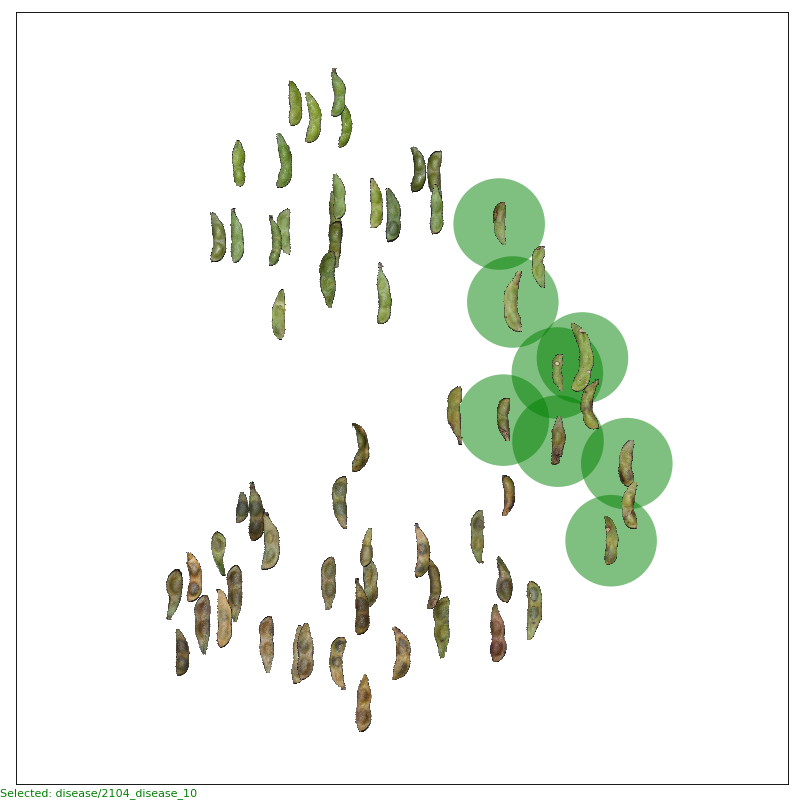

Starting stress = 0.37928573232962753 Processing...
Solution stress = 0.15152550900933415 Done.


In [22]:
plot_ax = create_plot(df_2D)
display(widgets.HBox([size_slider,size_apply_button]))
display(widgets.HBox([inverse_button, copy_button,create_reset_buttons()]))

In [23]:
point_attribute = create_checkbox()

interactive(children=(Checkbox(value=False, description='Toggle Titles', indent=False, layout=Layout(height='2…

interactive(children=(Checkbox(value=True, description='Toggle Images', indent=False, layout=Layout(height='20…

In [24]:
silhouette_score(df_2D[['x','y']], df_2D['label'])

0.2037872119971394

##  Image Activation Map
Click the **Visual Explainations** button below to display the weighted mask captured by the underlying model

In [25]:
attention = create_attention_map()

Button(description='Activation Map', style=ButtonStyle())

Output()

In [26]:
attention = create_visual_explainations()

Button(description='Visual Explainations', style=ButtonStyle())

Output()

In [27]:
attention = create_visual_explainations()

Button(description='Visual Explainations', style=ButtonStyle())

Output()

In [28]:
inverse = create_inverse_button(fig_show=False)

## Simulation Engine

* The labels for images should be accessable from the image file name, which is set to the index of the dataframe, the format of the image index should be:

- category/image_file_name
- e.g. horse/9a4e3fd565

In [29]:
def Sampler(data_2D,n_sample):
    """Given 2D dataframe, return a datafram with n samples for each class"""
    print('Initial s score is: ',silhouette_score(data_2D[['x','y']], data_2D['label']))    
    df_sample = data_2D.copy()
    df_sample['label'] = df_sample.index.str.split('/').str[:1].str.join('')
    selected_points = df_sample.groupby('label').apply(lambda group: group.sample(n_sample))
    selected_points.index = selected_points.index.droplevel(0)
    return selected_points


def InteractionSimulator(sample_data_2D):
    data_HD = normalized_df.loc[sample_data_2D.index]
    data_2D = pd.get_dummies(sample_data_2D['label'])
#    display(data_2D)
#    display(pd.DataFrame(distance_matrix_2D(data_2D)*100,index=data_2D.index,columns=data_2D.index,dtype=float))
    wts = inverse_DR(data_HD, data_2D)
    return wts


def EvaluationSimulator(n_control_points, output_file_mark="animal"):
    s_score_list = []
    wts_list = []
    for i in tqdm(range(1,n_control_points+1)):
        sample_df = Sampler(df_2D,n_sample=i)
        wts = InteractionSimulator(sample_df)
        wts.to_csv('./WeightsDirectory/'+str(output_file_mark) +'_iteration_'+str(i)+'.csv', header=True)
        updated_df_2D = dimension_reduction(normalized_df, weights)
        updated_df_2D['label'] = updated_df_2D.index.str.split('/').str[:1].str.join('')
        s_score = silhouette_score(updated_df_2D[['x','y']],updated_df_2D['label'])
        print("Updated s score after dragging: ", s_score)
        s_score_list.append(s_score)
        wts_list.append(wts)
    return s_score_list, wts_list

def create_load_weights_from_file(n_control_points, output_file_mark='animal'):
    load_button = widgets.Button(description="Load weights from file")
    def apply_button_clicked(change):
        # Use the slider values to re compute the DR and redraw the plot
        global weights, df_2D, paths
        weights = pd.read_csv('./WeightsDirectory/'+str(output_file_mark) +'_iteration_'+str(n_control_points)+'.csv')['Weight']
        weights.index = normalized_df.columns
        df_2D = dimension_reduction(normalized_df, weights)   
        draw_plot(plot_ax, df_2D, paths)
    load_button.on_click(apply_button_clicked)
    display(load_button)

In [30]:
# pod_s_score_list, pod_wts_lists = EvaluationSimulator(n_control_points=50, output_file_mark="pod")

In [31]:
# create_load_weights_from_file(n_control_points=5, output_file_mark='pod')

In [32]:
# print("select 4 images from each cat:")
# sample_df = Sampler(df_2D,n_sample=7)
# display(sample_df.head(10))
# InteractionSimulator(sample_df)

In [33]:
## The following code is for one iteration, then calculate the s_score for the updated projection
# from sklearn.metrics import silhouette_score

# test_df = dimension_reduction(normalized_df, weights)
# test_df['label'] = test_df.index.str.split('/').str[:1].str.join('')
# display(test_df)
# print("The s_score is:")
# silhouette_score(test_df[['x','y']], test_df['label'])

In [34]:
# from tqdm import tqdm
# s_score_list = []
# for i in tqdm(range(1,31)):
#     sample_df = Sampler(df_2D,n_sample=i)
#     PretendingUserDragging(sample_df,'iteration_'+str(i)+'.csv')
#     updated_df_2D = dimension_reduction(normalized_df, weights)
#     updated_df_2D['label'] = updated_df_2D.index.str.split('/').str[:1].str.join('')
#     s_score = silhouette_score(updated_df_2D[['x','y']],updated_df_2D['label'])
#     s_score_list.append(s_score)
# s_score_list

In [35]:
# plt.figure()
# plt.plot(s_score_list,marker='o',c='orange')
# plt.xlabel('Number of Control points')
# plt.ylabel('Silhouette Score')

In [36]:
# plt.figure()
# plt.plot(np.array(range(1,31)),s_score_list,marker='o',c='orange')
# plt.xlabel('Number of Control points per category')
# plt.ylabel('Silhouette Score')

In [37]:
! pwd

/Users/huiminhan/Desktop/InfoVis/VIS2022/Andromeda_IMG
